Завдання
---
* Розглянути три різні моделі: одинарне(SimpleExpSmoothing), подвійне(Holt) та потрійне(ExponentialSmoothing) згладжування.
* Побудувати відповідні прогнози
* В даному випадку тренд є лінійним та незатухаючим. Що можна сказати про інші параметри?


## Завантаження та огляд даних

In [345]:
import pandas as pd
data = pd.read_csv('data/airline-passengers.csv')
print(f'Dataset size = {len(data)}')
data.head()

Dataset size = 144


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<Axes: >

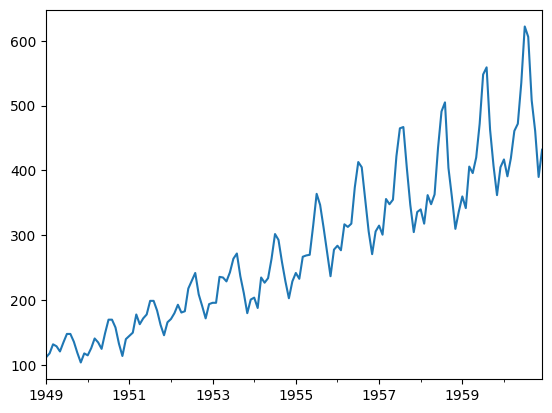

In [346]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)
data['Passengers'].plot()

In [347]:
test_set_size = 20
train, test = data[:-test_set_size + 1], data[-test_set_size:]
print(f"Train = {len(train)}, test = {len(test)}")
print(train.head())
print(test.head())

Train = 125, test = 20
            Passengers
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
            Passengers
1959-05-01         420
1959-06-01         472
1959-07-01         548
1959-08-01         559
1959-09-01         463


## Використання методів прогнозу: прості та згладжування

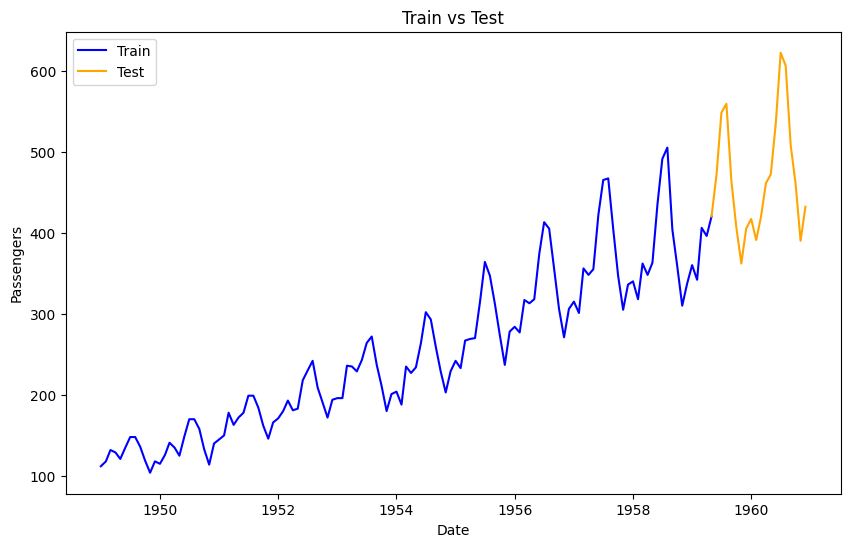

In [348]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def show_result(current_train, current_test, current_prediction=None, prediction_label=None, prediction_color=None):
    plt.figure(figsize=(10, 6))
    if current_prediction is not None:
        print(f'Mean squared error: {mean_squared_error(current_test, current_prediction)}')
        print(f'Mean absolute error: {mean_absolute_error(current_test, current_prediction)}')
        print(f'R2 score: {r2_score(current_test, current_prediction)}')
        plt.plot(current_prediction.index, current_prediction['Passengers'], label=prediction_label, color=prediction_color)

    plt.plot(current_train.index, current_train['Passengers'], label='Train', color='blue')
    plt.plot(current_test.index, current_test['Passengers'], label='Test', color='orange')
    plt.title("Train vs Test")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.legend()
    plt.show()

show_result(train, test)

Mean squared error: 7417.3
Mean absolute error: 62.4
R2 score: -0.43716879317193214


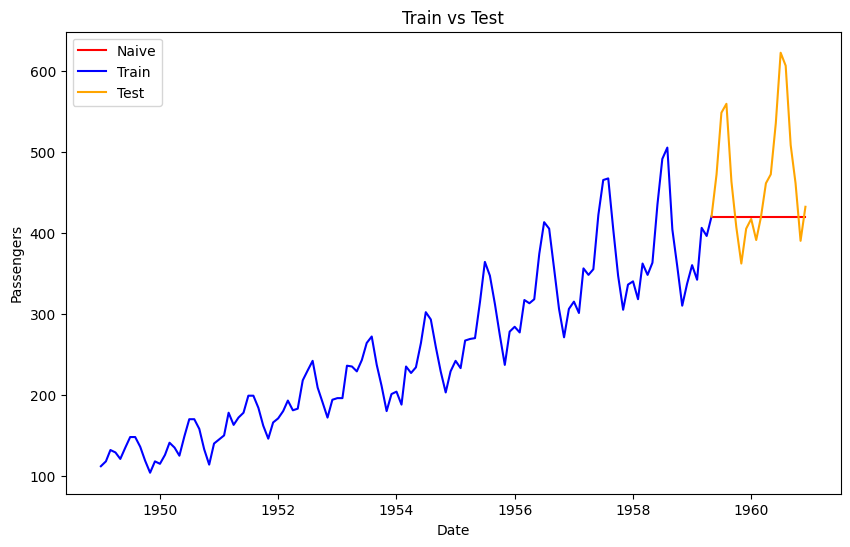

In [349]:
naive_prediction = pd.DataFrame(
    {'Passengers': [train['Passengers'].iloc[-1]] * len(test)},
    index=test.index
)
show_result(train, test, naive_prediction, 'Naive', prediction_color='red')

Mean squared error: 51832.603296
Mean absolute error: 216.036
R2 score: -9.043034517394718


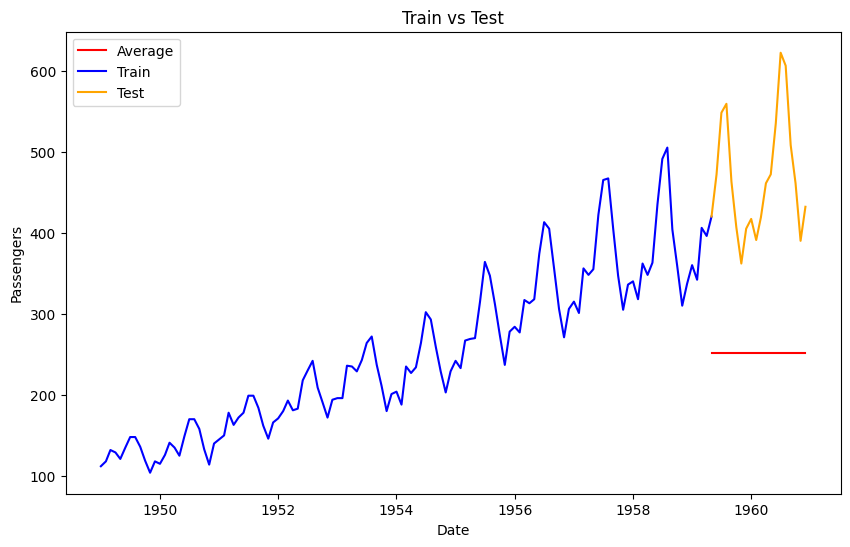

In [350]:
average_prediction = pd.DataFrame(
    {'Passengers': [train['Passengers'].mean()] * len(test)},
    index=test.index
)
show_result(train, test, average_prediction, 'Average', prediction_color='red')

Mean squared error: 10119.556944444448
Mean absolute error: 75.24166666666669
R2 score: -0.9607554556620161


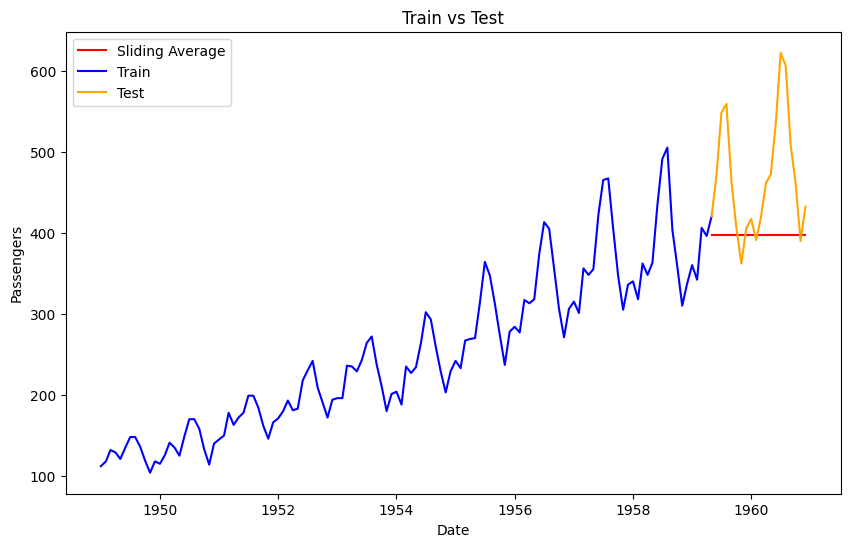

In [351]:
sliding_window_size = 12
sliding_average_prediction = pd.DataFrame(
    {'Passengers': [train['Passengers'][-sliding_window_size:].mean()] * len(test)}, 
    index=test.index
)
show_result(train, test, sliding_average_prediction, 'Sliding Average', prediction_color='red')

Mean squared error: 7428.691350914005
Mean absolute error: 62.4359273966467
R2 score: -0.4393759701832003


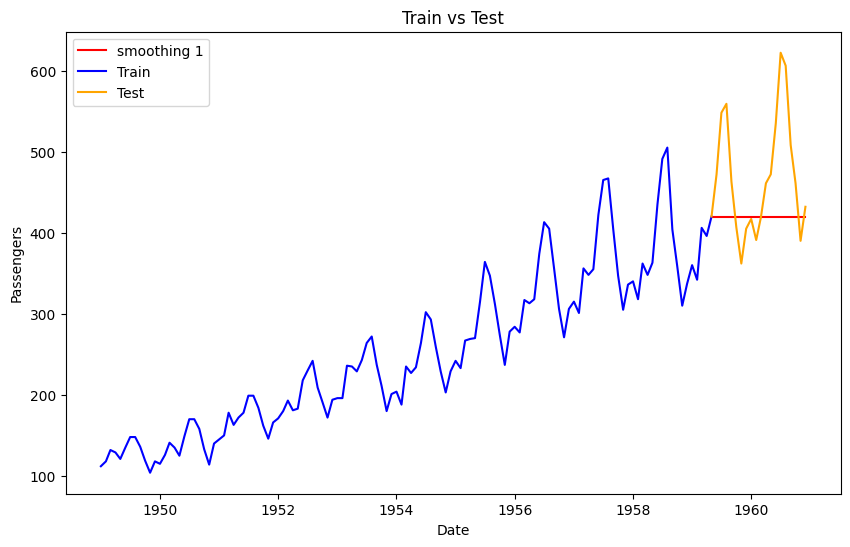

In [352]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

train.index = pd.to_datetime(train.index)
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)

mod_ss = SimpleExpSmoothing(train['Passengers'])
mod_ss_fitted = mod_ss.fit(optimized=True)

smoothing1 = mod_ss_fitted.forecast(test_set_size)

smoothing1 = pd.DataFrame(
    {'Passengers': smoothing1.values}, 
    index=test.index[:len(smoothing1)]
)
show_result(train, test, smoothing1, 'smoothing 1', prediction_color='red')


Mean squared error: 5344.45048788194
Mean absolute error: 60.47409360130071
R2 score: -0.03553549914880483


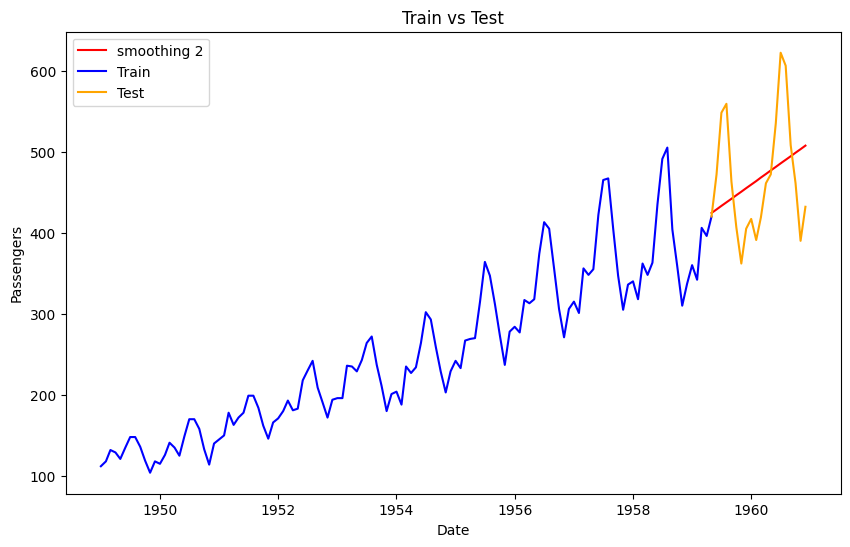

In [353]:
from statsmodels.tsa.holtwinters import Holt

mod_holt = Holt(train['Passengers'])
mod_holt_fitted = mod_holt.fit()

smoothing2 = mod_holt_fitted.forecast(test_set_size)

smoothing2 = pd.DataFrame(
    {'Passengers': smoothing2.values},
    index=test.index
)
show_result(train, test, smoothing2, 'smoothing 2', prediction_color='red')

Mean squared error: 3718.625765817914
Mean absolute error: 48.58237598597971
R2 score: 0.27948270878640713


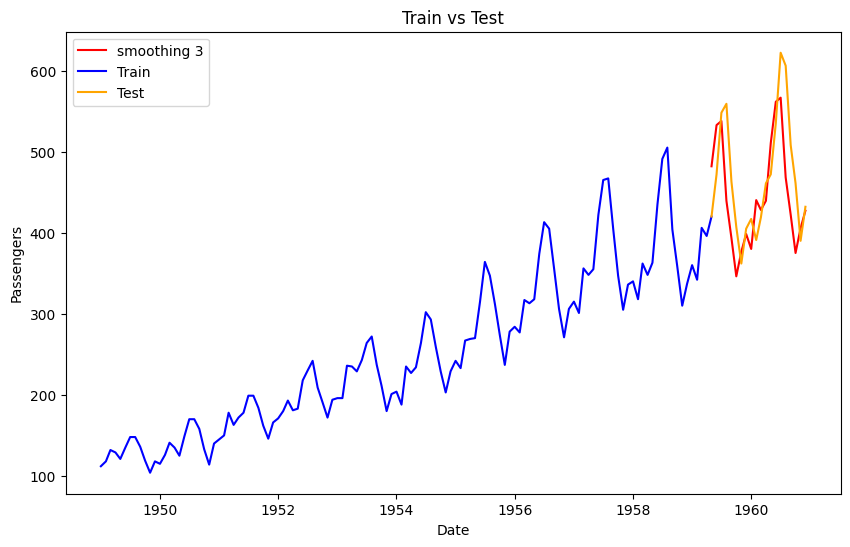

In [354]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

mod_hw = ExponentialSmoothing(
    train['Passengers'], 
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
mod_hw_fitted = mod_hw.fit(optimized=True)
smoothing3 = mod_hw_fitted.forecast(test_set_size)

smoothing3 = pd.DataFrame(
    {'Passengers': smoothing3.values}, 
    index=test.index
)

show_result(train, test, smoothing3, 'smoothing 3', prediction_color='red')

## Аналіз параметрів

<Axes: >

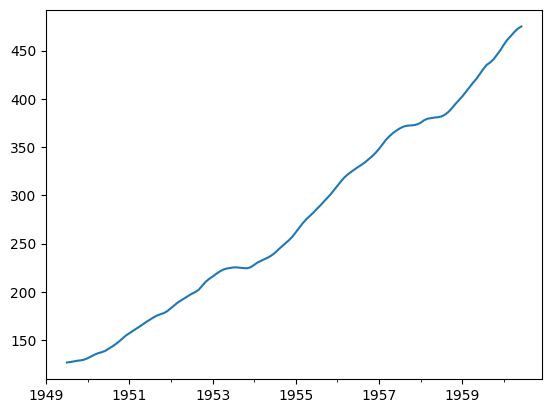

In [355]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_result = seasonal_decompose(data['Passengers'])
decomposition_result.trend.plot()

<Axes: >

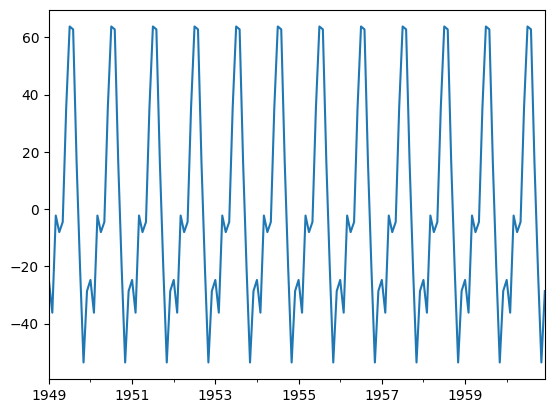

In [356]:
decomposition_result.seasonal.plot()

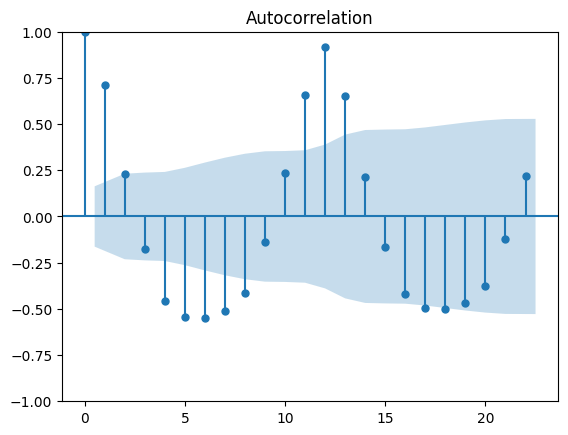

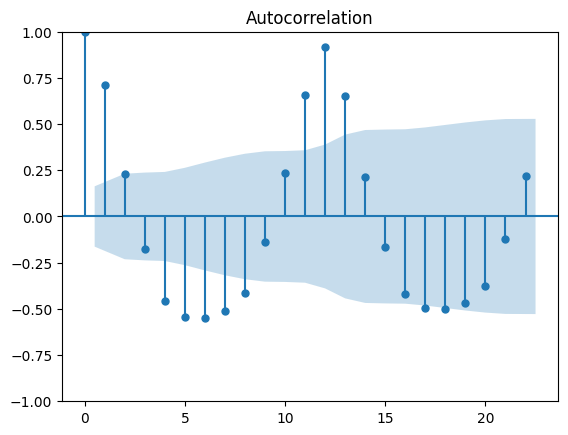

In [357]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(decomposition_result.seasonal)

Висновок
* Тренд - присутній стабільний лінійний зростаючий тренд
* Сезонність - присутній стабільний річний цикл, видно по графіку і по автокореляції, амлітуда збільшується з часом - мультиплікативна